# Bayesian logistic regression

Prior인 p(w)의 분포가 아래와 같은 Normal 분포를 가지고 있다고 가정합니다. 


$$ p(W) = Normal(w, \mu, \Sigma)$$


Likelihood 인  $p(y | X, W)$ 은 이항 분포를 가지고 있습니다.

$$p(y | X, W) = \Pi^N_{i=1} 
(\sigma(X_i^T \cdot W))^{yi}
(1-\sigma(X_i^T \cdot W))^{1-yi}
$$

prior 와 likelihood가 위와 같은 분포를 가질 때,  
posterior 인 $p(W | D)$ 은 아래와 같이 정의 가능합니다. 

$$
p(W | D) = \frac{likehood * prior}{\int likehood * prior} 
= \frac{p(y | X, W)p(W)}{\int p(y | X, W)p(W) dW}
$$



적분에 의해 w 항이 사리짐으로 위 수식은 아래와 같이 표현 가능합니다.   
그리고 분모 term 은 상수로 취급 가능합니다.   



$$ p(W | D) = \frac{p(y | X, W)p(W)}{ p(y | X)} \propto p(y | X, W)p(W)$$ 



## Laplace Approximation 을 활용한 Posterior 함수 근사

`Laplace` 근사를 활용해 `Posterior` 함수를 다항함수로 근사화합니다. 

Posterior 함수에 로그를 적용합니다. 

$$ log(p(W | D)) 
= log(\frac{p(y | X, W)p(W)}{ p(y | X)}) 
= log(p(y | X, W)) + log(p(W)) - log( p(y | X)) 
$$ 



위 수식을 미분시 상수값이 사라지기 때문에  
수식을 간편하게 표현하기 위해 아래와 같이 수식을 정리할수 있습니다.  

$$\Psi(\theta) = log(p(D | \theta) + log(p(\theta)) $$

위 함수($\Psi(\theta)$)을 최대화 하는  $\hat{\theta}$ 을 구합니다.  

위 함수($\Psi(\theta)$)를 최대화 하는 $\hat{\theta}$ 은 posterior $p(W | D)$를 최대화 합니다.

posterior를 최대화 하는 parameter의 estimate을 MAP(Maximum a posteriori)라고 합니다.

$$\hat{\theta} = argmax \ \Psi(\theta)$$



In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
def gardient_descent(f, y, x, w):
    lr = 0.0001
    delta = 0.0000001

    # gradient descent 
    derivate = (f(y, x, w + delta) - f(y, x, w)) / delta

    # estimate new theta 
    return w + derivate * lr, derivate


In [3]:
def get_prior(w, mu=0, std=1):
    prior = 1 / (np.sqrt(2 * np.pi) * std) * np.exp(-0.5 * ((w - mu) / std) ** 2)
    return prior

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [5]:
def get_loglikelihood(y, x, w):
    """
    Args:
        y, ndarray, shape 2d, (N, 1)
        x, ndarray, shape 2d, (N, n_features)
        w, ndarray, shape 2d, (n_features, 1)
    """
    return np.sum(np.log((sigmoid(x @ w) ** y) * ((1 - sigmoid(x @ w)) ** (1 - y))))



In [6]:
def psi(y, x, w):
    """
    Args:
        y, ndarray, shape 2d, (N, 1)
        x, ndarray, shape 2d, (N, n_features)
        w, ndarray, shape 2d, (n_features, 1)
    """

    return np.log(get_prior(w)) + get_loglikelihood(y, x, w)


In [7]:
# generate test dataset
np.random.seed(0)
x = np.random.normal(0, 2, size=1000).reshape(-1, 1)
noise = np.random.normal(0, 3, 1000).reshape(-1, 1)

y = 3 * x + 2 + noise
y = np.where(y > 0, 1, 0)
y = y.reshape(-1, 1)

init_w = np.random.normal(0, 1, 1).reshape(1, 1)

In [8]:
ws = []
drvs = []
psi_values = []
w = init_w
xs = range(1000)

for i in range(1000):
    psi_value = psi(y, x, w)
    w, drv = gardient_descent(psi, y, x, w)

    ws.append(w.reshape(-1))
    drvs.append(drv.reshape(-1))
    psi_values.append(psi_value.reshape(-1))

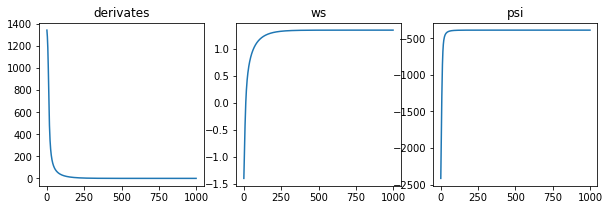

<Figure size 432x288 with 0 Axes>

In [9]:
fig, axes = plt.subplots(1 ,3)
fig.set_size_inches((10, 3))
axes = axes.ravel()

axes[0].plot(xs, np.array(drvs)[:, 0].tolist())
axes[0].set_title('derivates')
axes[1].plot(xs, np.array(ws)[:, 0].tolist())
axes[1].set_title('ws')
axes[2].plot(xs, np.array(psi_values)[:, 0].tolist())
axes[2].set_title('psi')

plt.show()
plt.tight_layout()

## Posterial distribution

In [10]:
def gardient_psi(y, x, w):
    delta = 0.00000001

    # gradient descent
    derivate = (psi(y, x, w + delta) - psi(y, x, w)) / delta
    return derivate


def hessian_psi(y, x, w):
    delta = 0.00000001
    return (gardient_psi(y, x, w + delta) - gardient_psi(y, x, w)) / delta


def get_posterior(y, x, w_hat):
    h = -hessian_psi(y, x, w_hat)
    return np.random.normal(w_hat.reshape(-1), 1 / h.reshape(-1), 10000), h


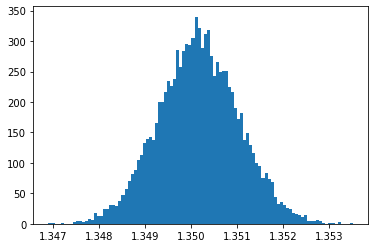

In [11]:
zs, h = get_posterior(y, x, w)
zs = zs.reshape(-1)
plt.hist(zs, bins=100)
plt.show()

## Making Predictions 

In [12]:
# generate test dataset
np.random.seed(1)
x_test = np.random.normal(0, 2, size=300).reshape(-1, 1)

mu = x_test @ w 
var = x_test**2*(1 / h)

In [14]:
np.random.seed(1)
noise = np.random.normal(0, 3, 300).reshape(-1, 1)

y_test = 3 * x_test + 2 + noise
y_test = np.where(y_test > 0, 1, 0)
y_test = y_test.reshape(-1, 1)

init_w = np.random.normal(0, 1, 1).reshape(1, 1)

In [15]:
a = mu / np.sqrt(1+var)

In [16]:
from scipy.stats import norm
pred = norm.cdf(a)

In [17]:
# dichotomize : 이분화
pred_cls = np.where(pred > 0.5, 1, 0)

In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
y_test = y_test.reshape(-1)
pred_cls = pred_cls.reshape(-1)
confusion_matrix(y_test, pred_cls)

array([[113,   0],
       [ 25, 162]])

In [19]:
np.stack([pred_cls, y_test], axis=-1)

array([[[1, 1]],

       [[0, 0]],

       [[0, 0]],

       [[0, 0]],

       [[1, 1]],

       [[0, 0]],

       [[1, 1]],

       [[0, 0]],

       [[1, 1]],

       [[0, 0]],

       [[1, 1]],

       [[0, 0]],

       [[0, 0]],

       [[0, 0]],

       [[1, 1]],

       [[0, 0]],

       [[0, 1]],

       [[0, 0]],

       [[1, 1]],

       [[1, 1]],

       [[0, 0]],

       [[1, 1]],

       [[1, 1]],

       [[1, 1]],

       [[1, 1]],

       [[0, 0]],

       [[0, 1]],

       [[0, 0]],

       [[0, 0]],

       [[1, 1]],

       [[0, 0]],

       [[0, 0]],

       [[0, 0]],

       [[0, 0]],

       [[0, 0]],

       [[0, 1]],

       [[0, 0]],

       [[1, 1]],

       [[1, 1]],

       [[1, 1]],

       [[0, 1]],

       [[0, 0]],

       [[0, 0]],

       [[1, 1]],

       [[1, 1]],

       [[0, 0]],

       [[1, 1]],

       [[1, 1]],

       [[1, 1]],

       [[1, 1]],

       [[1, 1]],

       [[0, 0]],

       [[0, 0]],

       [[0, 0]],

       [[0, 1]],

       [[1